### this notebook is dedicated to the computation of global map of relative difference / trends of aerosol parameters in between two years both for an ENSEMBLE of models and observations

In [1]:
# modules importation
from trends_functions import *
import iris
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import cartopy.crs as ccrs
from warnings import filterwarnings
filterwarnings('ignore')

In [11]:
# import seaborn style
sns.set()
sns.set_context("paper")
# sns.set_style("whitegrid")
sns.color_palette("muted")
# since each figure will be a subfigure, increase font_size
fscale = 1.2
sns.set(font_scale=fscale)

In [12]:
# computation parameters
params = get_params()

In [13]:
models = ['GEOS-i33p2_HIST', 'ECHAM6.3-HAM2.3-fSST_HIST', 'NorESM2-CPL-NEWTEST_HIST']
models = ['NorESM2-CPL-NEWTEST_HIST']
od_vars = ['od550aer', 'od550dust', 'od550ss', 'od550so4', 'od550oa', 'od550bc']
emi_vars = ['emidust', 'emiss', 'emiso4', 'emioa', 'emibc']
load_vars = ['loaddust', 'loadss', 'loadso4', 'loadoa', 'loadbc']
other_vars = ['concso4']
varss = od_vars + emi_vars + load_vars + other_vars

### compute 5x5 files for each species OD and EMI for some models

In [14]:
y1, y2 = 2000, 2014

In [15]:
DATA = {}
for var in varss:
    DATA[var] = {}
    #get models from params
    params = fill_params(params, var)

    #for the models, set mon_dim to zero
    params['min_dim'] = 0
    mod_var = params['mod_var']

    mod_sources = params['models']
    

    resol = 2
    lons = np.arange(-180, 180, resol)
    lats = np.arange(-90, 90, resol)
    sample_points = [('latitude',lats), ('longitude', lons)]

    MOD_DATA = []
    for model in models:
        print(var,' - ',model)
        params['source'] = model

        #check if model in cache
        fn = 'cache/'+model+'_'+var+'-'+str(resol)+'x'+str(resol)+'.pkl'
        if os.path.isfile(fn):
            print('use pickle file')
            # for reading also binary mode is important 
            pklfile = open(fn, 'rb')      
            mod_data = pickle.load(pklfile) 
            pklfile.close()
        else:
            print('read netcdf')
            reader = pya.io.ReadGridded(model)
            mod_data = reader.read_var(mod_var, ts_type='daily')
            #crop the cube to interest period, so can handle WORLD region
            mod_data = mod_data.crop(time_range=(y1, str(y2)))
            
            #if cube has 4 dimensions, extract first level
            if mod_var in ['concso4', 'concpm10', 'concpm25'] and len(np.shape(mod_data))==4:
                print('cube has 4 dimension, extract first layer')
                mod_data = mod_data.extract_surface_level()
            mod_data = mod_data.resample_time(to_ts_type='monthly')
            mod_data = mod_data.interpolate(sample_points,scheme='nearest')

            #write picke file in cache directory
            pklfile = open(fn, 'ab') 

            # source, destination 
            pickle.dump(mod_data, pklfile)                      
            pklfile.close()
        DATA[var][model] = mod_data

od550aer  -  NorESM2-CPL-NEWTEST_HIST
use pickle file
od550dust  -  NorESM2-CPL-NEWTEST_HIST
use pickle file
od550ss  -  NorESM2-CPL-NEWTEST_HIST
use pickle file
od550so4  -  NorESM2-CPL-NEWTEST_HIST
use pickle file
od550oa  -  NorESM2-CPL-NEWTEST_HIST
use pickle file
od550bc  -  NorESM2-CPL-NEWTEST_HIST
use pickle file
emidust  -  NorESM2-CPL-NEWTEST_HIST
use pickle file
emiss  -  NorESM2-CPL-NEWTEST_HIST
use pickle file
emiso4  -  NorESM2-CPL-NEWTEST_HIST
use pickle file
emioa  -  NorESM2-CPL-NEWTEST_HIST
use pickle file
emibc  -  NorESM2-CPL-NEWTEST_HIST
use pickle file
loaddust  -  NorESM2-CPL-NEWTEST_HIST
use pickle file
loadss  -  NorESM2-CPL-NEWTEST_HIST
use pickle file
loadso4  -  NorESM2-CPL-NEWTEST_HIST
use pickle file
loadoa  -  NorESM2-CPL-NEWTEST_HIST
use pickle file
loadbc  -  NorESM2-CPL-NEWTEST_HIST
use pickle file
concso4  -  NorESM2-CPL-NEWTEST_HIST
use pickle file


### compute trends for each variable

In [7]:
y1, y2 = 2000, 2014

In [8]:
RTRENDS = {}
ATRENDS = {}

for var in varss:
    RTRENDS[var] = {}
    ATRENDS[var] = {}
    
    #get models from params
    params = fill_params(params, var)

    #for the models, set mon_dim to zero
    params['min_dim'] = 0
    mod_var = params['mod_var']
    
    for model in models:
        #check if trend is in cache
        fn1 = 'cache/map_trend/rslopes_'+model+'_'+var+'-'+str(resol)+'x'+str(resol)+'.pkl'
        fn2 = 'cache/map_trend/aslopes_'+model+'_'+var+'-'+str(resol)+'x'+str(resol)+'.pkl'
        
        if os.path.isfile(fn1) and os.path.isfile(fn2):
            print(var,model,'use pickle',fn1)
            # for reading also binary mode is important 
            pklfile = open(fn1, 'rb')      
            RTRENDS[var][model] = pickle.load(pklfile) 
            pklfile.close()
            # for reading also binary mode is important 
            pklfile = open(fn2, 'rb')      
            ATRENDS[var][model] = pickle.load(pklfile) 
            pklfile.close()
        else:
            print(var,model,'compute trend')
            fn0 = 'cache/'+model+'_'+var+'-'+str(resol)+'x'+str(resol)+'.pkl'
            # for reading also binary mode is important 
            pklfile = open(fn0, 'rb')      
            mod_data = pickle.load(pklfile) 
            pklfile.close()

            #average model data per year
            mod_data = mod_data.resample_time(to_ts_type='yearly')

            #initialize empty trends
            rslopes = np.empty((np.shape(mod_data)[1],np.shape(mod_data)[2]))
            aslopes = np.empty((np.shape(mod_data)[1],np.shape(mod_data)[2]))
            pvals = np.empty((np.shape(mod_data)[1],np.shape(mod_data)[2]))

            rslopes[:] = np.nan
            aslopes[:] = np.nan
            pvals[:] = np.nan
            for ilat in np.arange((np.shape(mod_data)[1])):
                print(ilat,'/',np.shape(mod_data)[1], end="\r")
                for ilon in np.arange((np.shape(mod_data)[2])):
                    x = np.array([int(str(date)[0:4]) for date in mod_data.time_stamps()])
                    y = np.array(mod_data.data[:,ilat,ilon])

                    #get indexes within period
                    iok = [i for i, year in enumerate(x) if year>=y1 and year<=y2]
                    x = x[iok]
                    y = y[iok]

                    if len(x)>2:
                        trend = compute_lin_trend(x, y, params)
                        rslopes[ilat, ilon] = trend[params['period']]['rel_slp']
                        aslopes[ilat, ilon] = trend[params['period']]['a']
                        pvals[ilat, ilon] = trend[params['period']]['pval']
            
            RTRENDS[var][model] = rslopes
            ATRENDS[var][model] = aslopes
            
            #writes pickle file
            pklfile = open(fn1, 'ab') 
            # source, destination 
            pickle.dump(rslopes, pklfile)
            pklfile.close()
            
            #writes pickle file
            pklfile = open(fn2, 'ab') 
            # source, destination 
            pickle.dump(aslopes, pklfile)
            pklfile.close()

od550aer NorESM2-CPL-NEWTEST_HIST use pickle cache/map_trend/rslopes_NorESM2-CPL-NEWTEST_HIST_od550aer-2x2.pkl
od550dust NorESM2-CPL-NEWTEST_HIST use pickle cache/map_trend/rslopes_NorESM2-CPL-NEWTEST_HIST_od550dust-2x2.pkl
od550ss NorESM2-CPL-NEWTEST_HIST use pickle cache/map_trend/rslopes_NorESM2-CPL-NEWTEST_HIST_od550ss-2x2.pkl
od550so4 NorESM2-CPL-NEWTEST_HIST use pickle cache/map_trend/rslopes_NorESM2-CPL-NEWTEST_HIST_od550so4-2x2.pkl
od550oa NorESM2-CPL-NEWTEST_HIST use pickle cache/map_trend/rslopes_NorESM2-CPL-NEWTEST_HIST_od550oa-2x2.pkl
od550bc NorESM2-CPL-NEWTEST_HIST use pickle cache/map_trend/rslopes_NorESM2-CPL-NEWTEST_HIST_od550bc-2x2.pkl
emidust NorESM2-CPL-NEWTEST_HIST use pickle cache/map_trend/rslopes_NorESM2-CPL-NEWTEST_HIST_emidust-2x2.pkl
emiss NorESM2-CPL-NEWTEST_HIST use pickle cache/map_trend/rslopes_NorESM2-CPL-NEWTEST_HIST_emiss-2x2.pkl
emiso4 NorESM2-CPL-NEWTEST_HIST use pickle cache/map_trend/rslopes_NorESM2-CPL-NEWTEST_HIST_emiso4-2x2.pkl
emioa NorESM2-CPL

### plot that

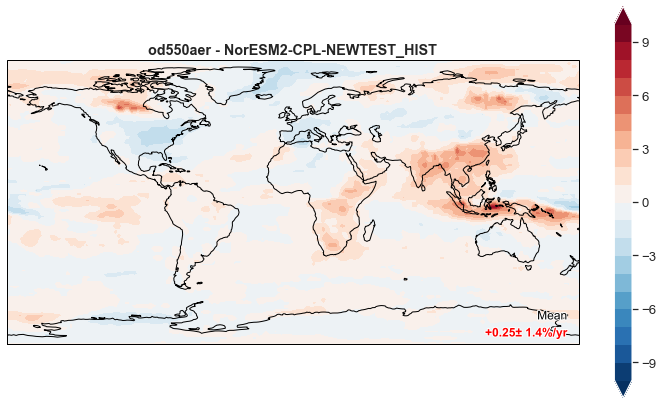

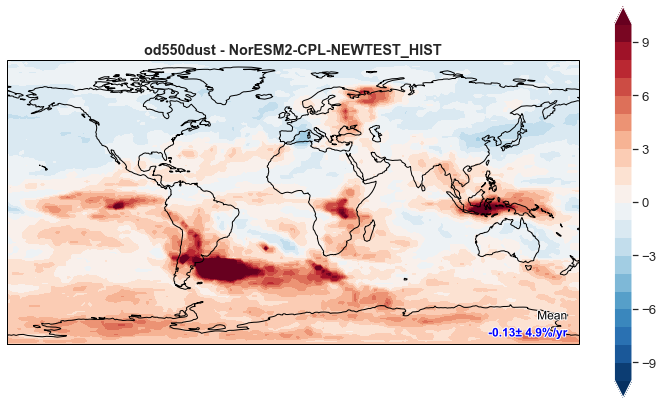

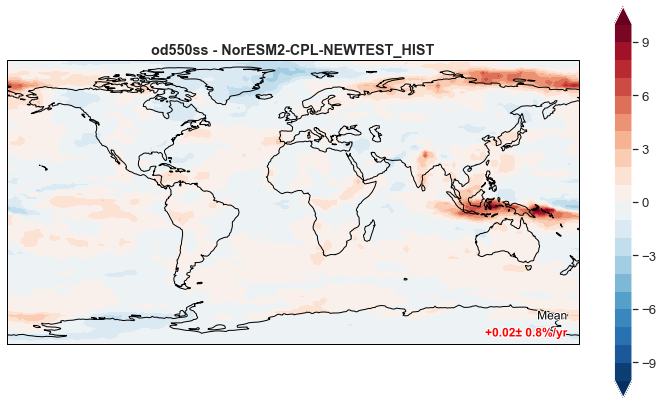

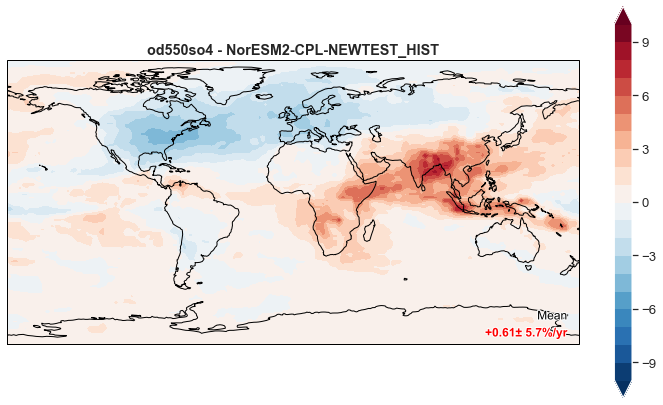

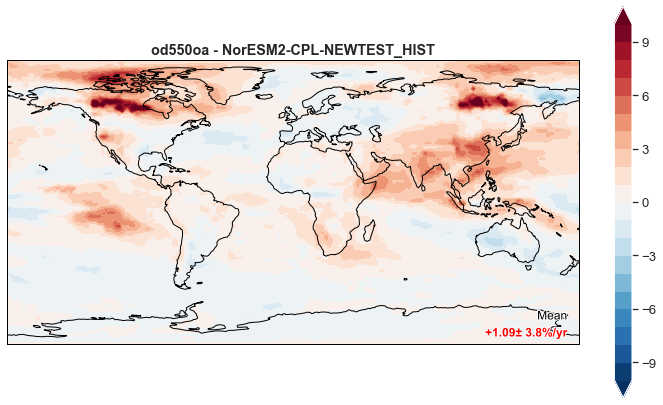

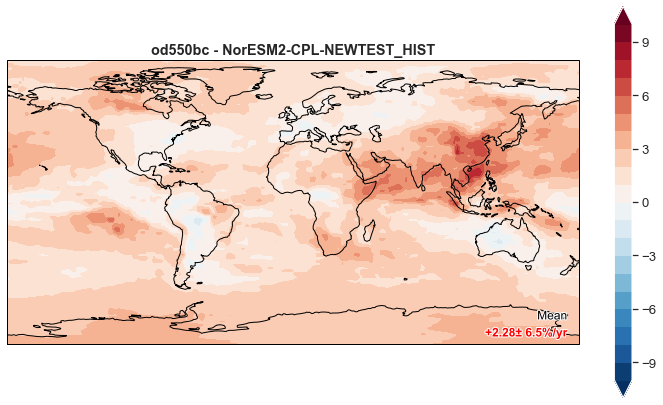

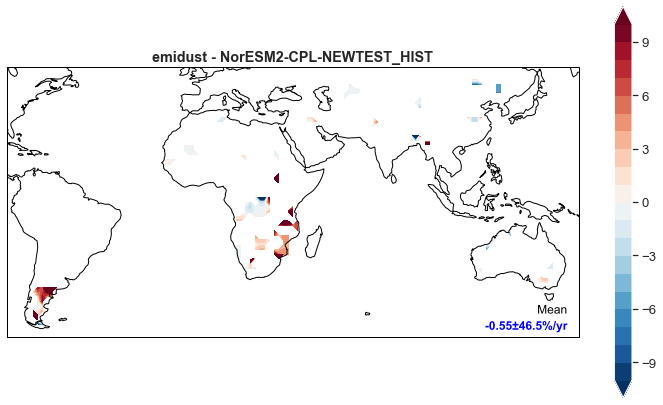

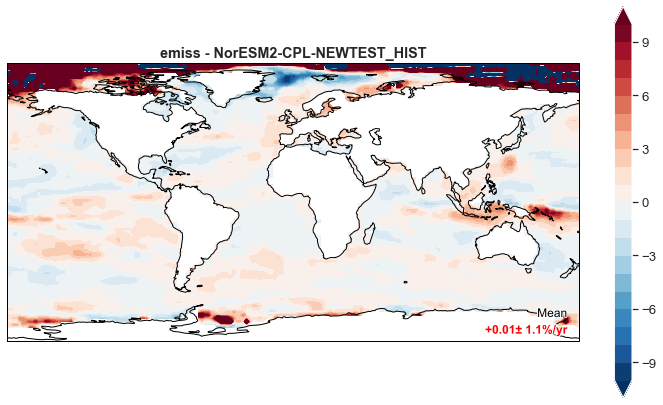

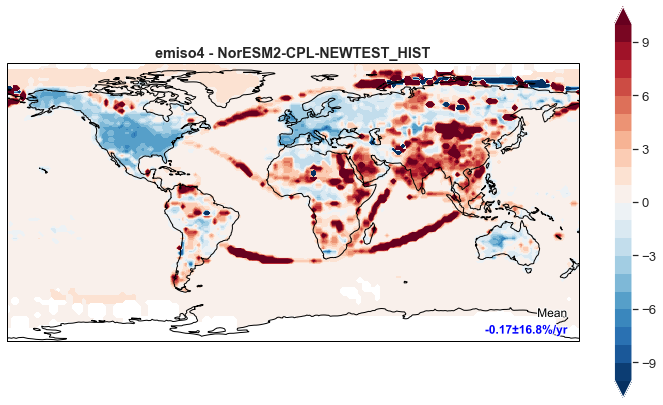

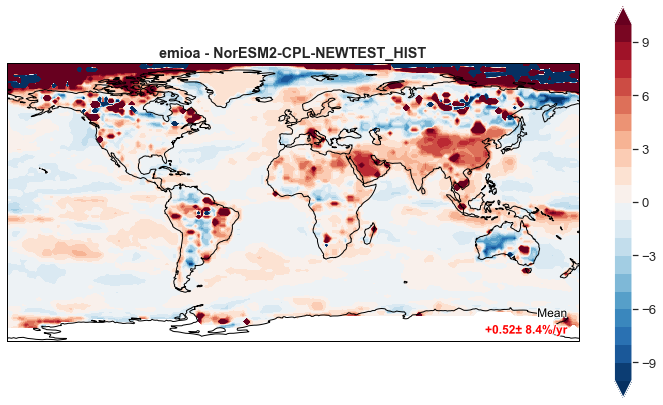

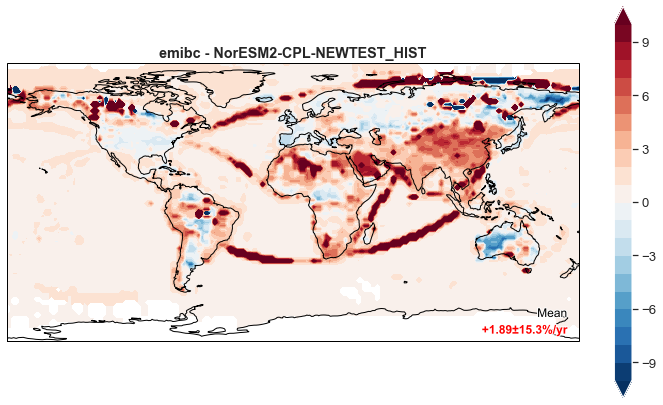

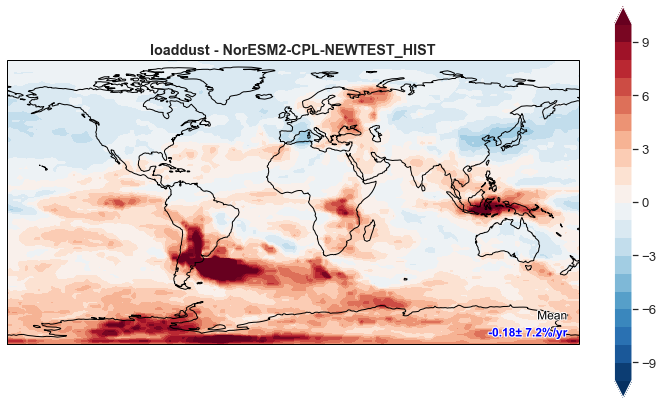

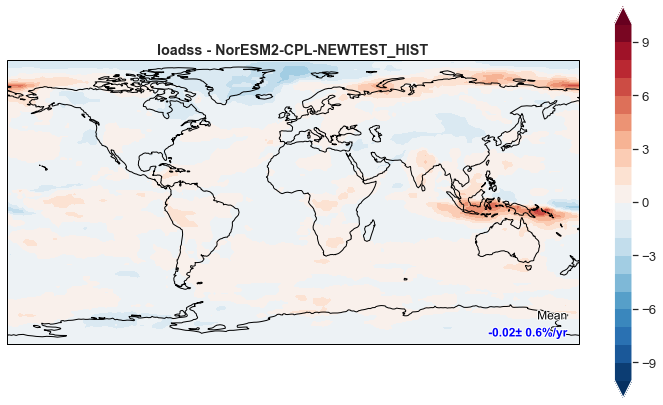

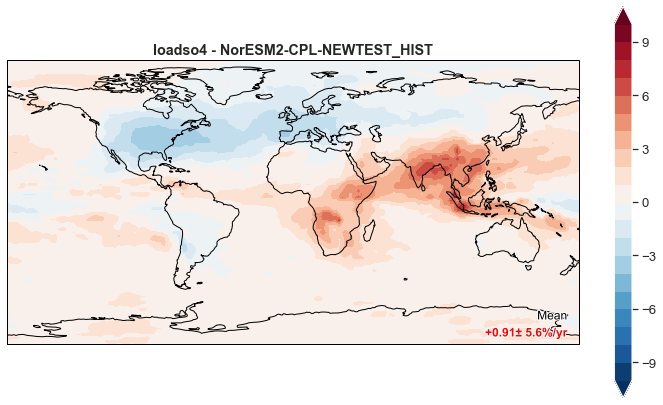

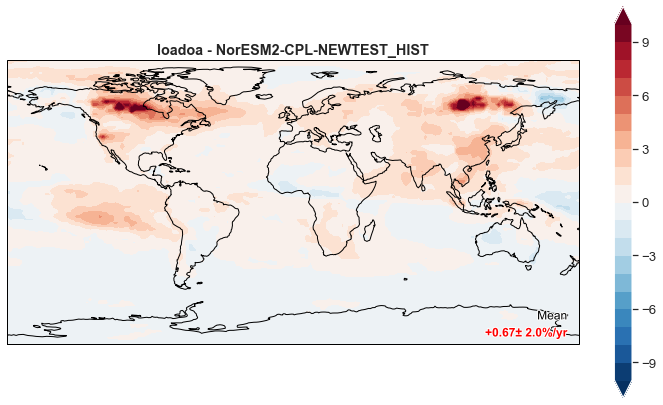

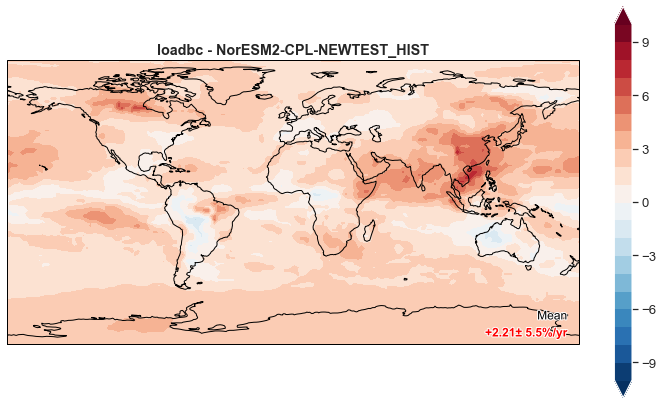

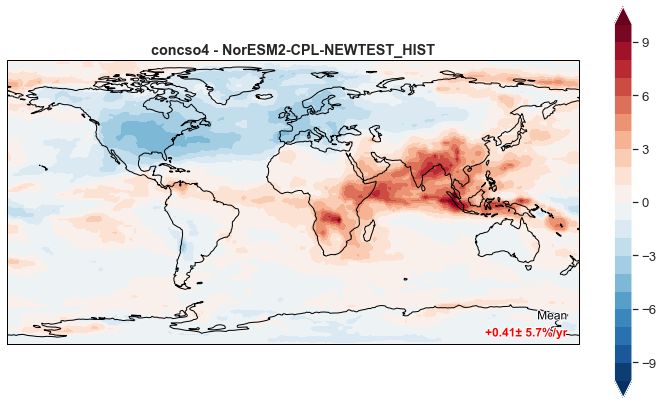

In [10]:
for var in varss:
    for model in models:
        aslopes = ATRENDS[var][model]
        rslopes = RTRENDS[var][model]
        
        #plot it
        nl, nc = 1, 1
        fs = 0.8
        import cartopy.crs as ccrs
        import matplotlib.patheffects as PathEffects
        plt.figure(figsize=(16*fs,9*fs))
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.coastlines()

        #add mean trend in lower left corner
        val0 = np.nanmean(DATA[var][model][0,:,:].data)
        mean_slope = np.nanmean(aslopes)*100/np.nanmean(val0)
        std_slope = np.nanstd(aslopes)*100/np.nanmean(val0)
        
        if mean_slope>0:
            fcolor = 'red'
        else:
            fcolor = 'blue'
        txt_source = '{:+4.2f}±{:4.1f}%/yr'.format(mean_slope, std_slope)
        txt = ax.text(0.98,0.08,'Mean',ha='right',va='bottom',transform=ax.transAxes,
                       fontsize=12,fontweight='normal',
                       color='black', zorder=99
                      )
        txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
        txt2 = ax.text(0.98,0.02,txt_source,ha='right',va='bottom',transform=ax.transAxes,
                       fontsize=12,fontweight='bold',
                       color=fcolor, zorder=99
                      )
        txt2.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
        #txt2.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

        cmin, cmax = -10, 10
        im = ax.contourf(lons,lats,rslopes,levels=np.arange(cmin,cmax+1,1),vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree(),cmap='RdBu_r',extend='both')
        plt.colorbar(im)
        plt.title(var+' - '+model,fontweight='bold')
        plt.savefig('figs/maps/trends/'+model+'-'+var+'.png', dpi=300, bbox_inches='tight')

### Plot time series of requested parameter and model

In [19]:
var = 'loaddust'
mod = 'NorESM2-CPL-NEWTEST_HIST'
mod_data = DATA[var][mod]

Year Load
2000 1.2989361e-05
2001 1.1839097e-05
2002 1.2988415e-05
2003 1.3330432e-05
2004 1.2291703e-05
2005 1.3730873e-05
2006 1.29466425e-05
2007 1.193835e-05
2008 1.325721e-05
2009 1.2838608e-05
2010 1.4162876e-05
2011 1.2928398e-05
2012 1.2114497e-05
2013 1.2700987e-05
2014 1.1967761e-05


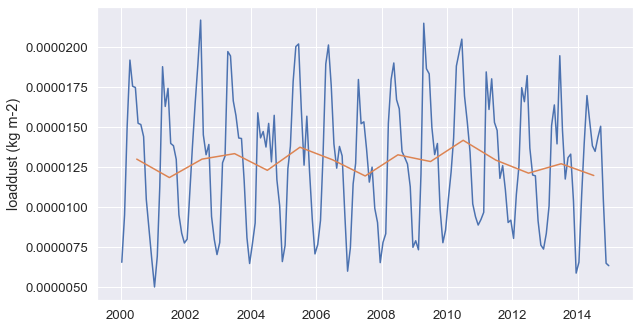

In [49]:
#monthly data
time = mod_data.time_stamps()
avg = []
for i, t in enumerate(time):
    avg.append(np.nanmean(mod_data[i,:,:].data))

#add yearly averages
ymod_data = mod_data.resample_time('yearly')
ytime = ymod_data.time_stamps()
yavg = []

print('Year', 'Load')
for i, t in enumerate(ytime):
    yavg.append(np.nanmean(ymod_data[i,:,:].data))
    print(t.item().year,yavg[i])
    
nl, nc = 1, 1
fs = 0.6
plt.figure(figsize=(16*fs,9*fs))

plt.plot(time, avg)
plt.plot(ytime, yavg)

plt.ylabel(var+' ('+mod_data.unit.origin+')')
plt.savefig('../load_dust.png', dpi=300, bbox_inches='tight')

In [47]:
t.item().year

2014